## Imports and Helper Classes

In [13]:
import logging
import os
import torch.optim as optim
import torch.nn as nn
from models.gmm import GMMDist, GMMDistAnneal
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import seaborn as sns
import numpy as np
sns.set()
sns.set_style('white')

## Main Functions

### Denoising Score Matching (Eq. 2)

The objective function for Denoising Score Matching is given by:

$$J_{DSM}(\theta) = \frac{1}{2} \mathbb{E}_{q_\sigma(\tilde{x}|x)p_{data}(x)} [ || s_\theta(\tilde{x}) - \nabla_{\tilde{x}} \log q_\sigma(\tilde{x}|x) ||_2^2 ]$$

where $\nabla_{\tilde{x}} \log q_\sigma(\tilde{x}|x) = \frac{x - \tilde{x}}{\sigma^2}$ for Gaussian noise.

In [14]:
def dsm_score_estimation(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)

    return loss

### Annealed Denoising Score Matching (Eq. 5)

The annealed objective function is:

$$\mathcal{L}(\theta; \{ \sigma_i \}_{i=1}^L) = \frac{1}{L} \sum_{i=1}^L \lambda(\sigma_i) \mathbb{E}_{p_{data}(x)} \mathbb{E}_{q_{\sigma_i}(\tilde{x}|x)} [ || s_\theta(\tilde{x}, \sigma_i) + \frac{\tilde{x} - x}{\sigma_i^2} ||_2^2 ]$$

where $\lambda(\sigma_i) = \sigma_i^2$.

In [15]:
def anneal_dsm_score_estimation(scorenet, samples, labels, sigmas, anneal_power=2.):
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
    perturbed_samples = samples + torch.randn_like(samples) * used_sigmas
    target = - 1 / (used_sigmas ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples, labels)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** anneal_power

    return loss.mean(dim=0)

In [16]:
def langevin_dynamics(score, init, lr=0.1, step=1000):
    for i in range(step):
        current_lr = lr
        init = init + current_lr / 2 * score(init).detach()
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init

In [17]:
class ConditionalScoreNet(nn.Module):
    def __init__(self, n_classes, hidden_units=128):
        super().__init__()
        self.embed = nn.Embedding(n_classes, hidden_units)
        self.main = nn.Sequential(
            nn.Linear(2 + hidden_units, hidden_units),
            nn.Softplus(),
            nn.Linear(hidden_units, hidden_units),
            nn.Softplus(),
            nn.Linear(hidden_units, 2),
        )

    def forward(self, x, labels):
        embed = self.embed(labels)
        x = torch.cat([x, embed], dim=-1)
        return self.main(x)

### Annealed Langevin Dynamics (Algorithm 1 & Eq. 4)

**Algorithm 1** Annealed Langevin Dynamics
1. **Input:** $\{ \sigma_i \}_{i=1}^L, \epsilon, T$
2. **Initialize** $\tilde{x}_0$
3. **For** $i = 1$ **to** $L$ **do**
4.    $\alpha_i \leftarrow \epsilon \cdot \sigma_i^2 / \sigma_L^2$
5.    **For** $t = 1$ **to** $T$ **do**
6.        $z_t \sim \mathcal{N}(0, I)$
7.        $\tilde{x}_t \leftarrow \tilde{x}_{t-1} + \frac{\alpha_i}{2} s_\theta(\tilde{x}_{t-1}, \sigma_i) + \sqrt{\alpha_i} z_t$
8.    **End For**
9.    $\tilde{x}_0 \leftarrow \tilde{x}_T$
10. **End For**
11. **Output** $\tilde{x}_T$

The update rule (Eq. 4) is:
$$\tilde{x}_t = \tilde{x}_{t-1} + \frac{\alpha_i}{2} s_\theta(\tilde{x}_{t-1}, \sigma_i) + \sqrt{\alpha_i} z_t$$

In [18]:
def anneal_langevin_dynamics(score, init, sigmas, lr=0.1, n_steps_each=100):
    for sigma in sigmas:
        for i in range(n_steps_each):
            current_lr = lr * (sigma / sigmas[-1]) ** 2
            init = init + current_lr / 2 * score(init, sigma).detach()
            init = init + torch.randn_like(init) * np.sqrt(current_lr)

    return init

In [19]:
def get_mesh(left_bound, right_bound, grid_size=100, device=None):
    x = np.linspace(left_bound, right_bound, grid_size)
    y = np.linspace(left_bound, right_bound, grid_size)
    mesh = []
    for i in x:
        for j in y:
            mesh.append(np.asarray([i, j]))
    mesh = np.stack(mesh, axis=0)
    mesh = torch.from_numpy(mesh).float()
    if device is not None:
        mesh = mesh.to(device)
    return mesh

def plot_density(teacher, left_bound, right_bound, ax=None, device=None):
    mesh = get_mesh(left_bound, right_bound, grid_size=100, device=device)
    logp_true = teacher.log_prob(mesh)
    logp_true = logp_true.view(100, 100).exp()

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.axis('off')
    ax.imshow(np.flipud(logp_true.cpu().numpy()), cmap='inferno', extent=[left_bound, right_bound, left_bound, right_bound])
    ax.set_title('Data density')

def plot_vector_field(scores, mesh_np, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.axis('off')
    ax.quiver(mesh_np[:, 0], mesh_np[:, 1], scores[:, 0], scores[:, 1], width=0.005)
    ax.set_title(title)
    ax.set_aspect('equal')

def plot_scatter(samples, title, left_bound, right_bound, ax=None, s=0.1):
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.scatter(samples[:, 0], samples[:, 1], s=s)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlim([left_bound, right_bound])
    ax.set_ylim([left_bound, right_bound])

In [20]:
def visualize_score_matching(teacher, model, left_bound=-1., right_bound=1., savefig=None, step=None, device=None):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # 1. Data Density
    plot_density(teacher, left_bound, right_bound, ax=axes[0], device=device)

    # Prepare mesh for vector fields
    mesh = get_mesh(left_bound, right_bound, grid_size=20, device=device)
    mesh_np = mesh.detach().cpu().numpy()

    # 2. Estimated Scores
    scores = model(mesh.detach()).detach().cpu().numpy()
    plot_vector_field(scores, mesh_np, 'Estimated scores', ax=axes[1])

    # 3. Data Samples
    samples = teacher.sample((1280,)).detach().cpu().numpy()
    plot_scatter(samples, 'Data samples', left_bound, right_bound, ax=axes[2])

    # 4. Langevin Dynamics (Model)
    samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
    samples = langevin_dynamics(model, samples).detach().numpy()
    plot_scatter(samples, 'Langevin dynamics (Model)', left_bound, right_bound, ax=axes[3])

    # 5. Data Scores (Ground Truth)
    def data_score(x):
        x = x.detach()
        x.requires_grad_(True)
        y = teacher.log_prob(x).sum()
        return autograd.grad(y, x)[0]

    scores = data_score(mesh).detach().cpu().numpy()
    plot_vector_field(scores, mesh_np, 'Data scores', ax=axes[4])

    # 6. Langevin Dynamics (Data)
    samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
    samples = langevin_dynamics(data_score, samples).detach().numpy()
    plot_scatter(samples, 'Langevin dynamics (Data)', left_bound, right_bound, ax=axes[5])

    plt.tight_layout()
    if savefig is not None and step is not None:
        plt.savefig(os.path.join(savefig, f"{step}_combined.png"))
        plt.close()
    else:
        plt.show()

In [21]:
import imageio

def visualize_annealed_langevin(teacher, score_fn, sigmas, left_bound=-8, right_bound=8, device=None):
    sns.set(font_scale=1.3)
    sns.set_style('white')

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    # 1. Data Density
    plot_density(teacher, left_bound, right_bound, ax=axes[0], device=device)

    # 2. I.I.D Samples
    samples = teacher.sample((1280,))
    if device is not None:
        samples = samples.to(device)
    samples = samples.detach().cpu().numpy()
    plot_scatter(samples, 'i.i.d samples', left_bound, right_bound, ax=axes[1], s=0.2)

    # 3. Standard Langevin Dynamics Samples (using smallest sigma)
    samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
    if device is not None:
        samples = samples.to(device)
    # Use the score function for the smallest sigma (last one)
    score_fn_smallest = lambda x: score_fn(x, sigmas[-1])
    samples = langevin_dynamics(score_fn_smallest, samples).detach().cpu().numpy()
    plot_scatter(samples, 'Langevin dynamics samples', left_bound, right_bound, ax=axes[2], s=0.2)

    # 4. Annealed Langevin Dynamics Samples
    samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
    if device is not None:
        samples = samples.to(device)
    samples = anneal_langevin_dynamics(score_fn, samples, sigmas).detach().cpu().numpy()
    plot_scatter(samples, 'Annealed Langevin dynamics samples', left_bound, right_bound, ax=axes[3], s=0.2)

    plt.tight_layout()
    plt.show()

    # 5. Visualize scores for different sigmas and create GIF
    mesh = get_mesh(left_bound, right_bound, grid_size=20, device=device)
    mesh_np = mesh.detach().cpu().numpy()
    
    images = []
    if not os.path.exists('tmp_gif'):
        os.makedirs('tmp_gif')

    for i, sigma in enumerate(sigmas):
        scores = score_fn(mesh, sigma).detach().cpu().numpy()
        
        fig_gif, ax_gif = plt.subplots()
        plot_vector_field(scores, mesh_np, 'Scores (sigma={:.2f})'.format(sigma), ax=ax_gif)
        filename = f'tmp_gif/sigma_{i}.png'
        fig_gif.savefig(filename)
        plt.close(fig_gif)
        images.append(imageio.imread(filename))
    
    imageio.mimsave('annealed_scores.gif', images, duration=0.2)
    print("GIF saved as annealed_scores.gif")
    
    # Clean up tmp files
    import shutil
    shutil.rmtree('tmp_gif')

## Execution

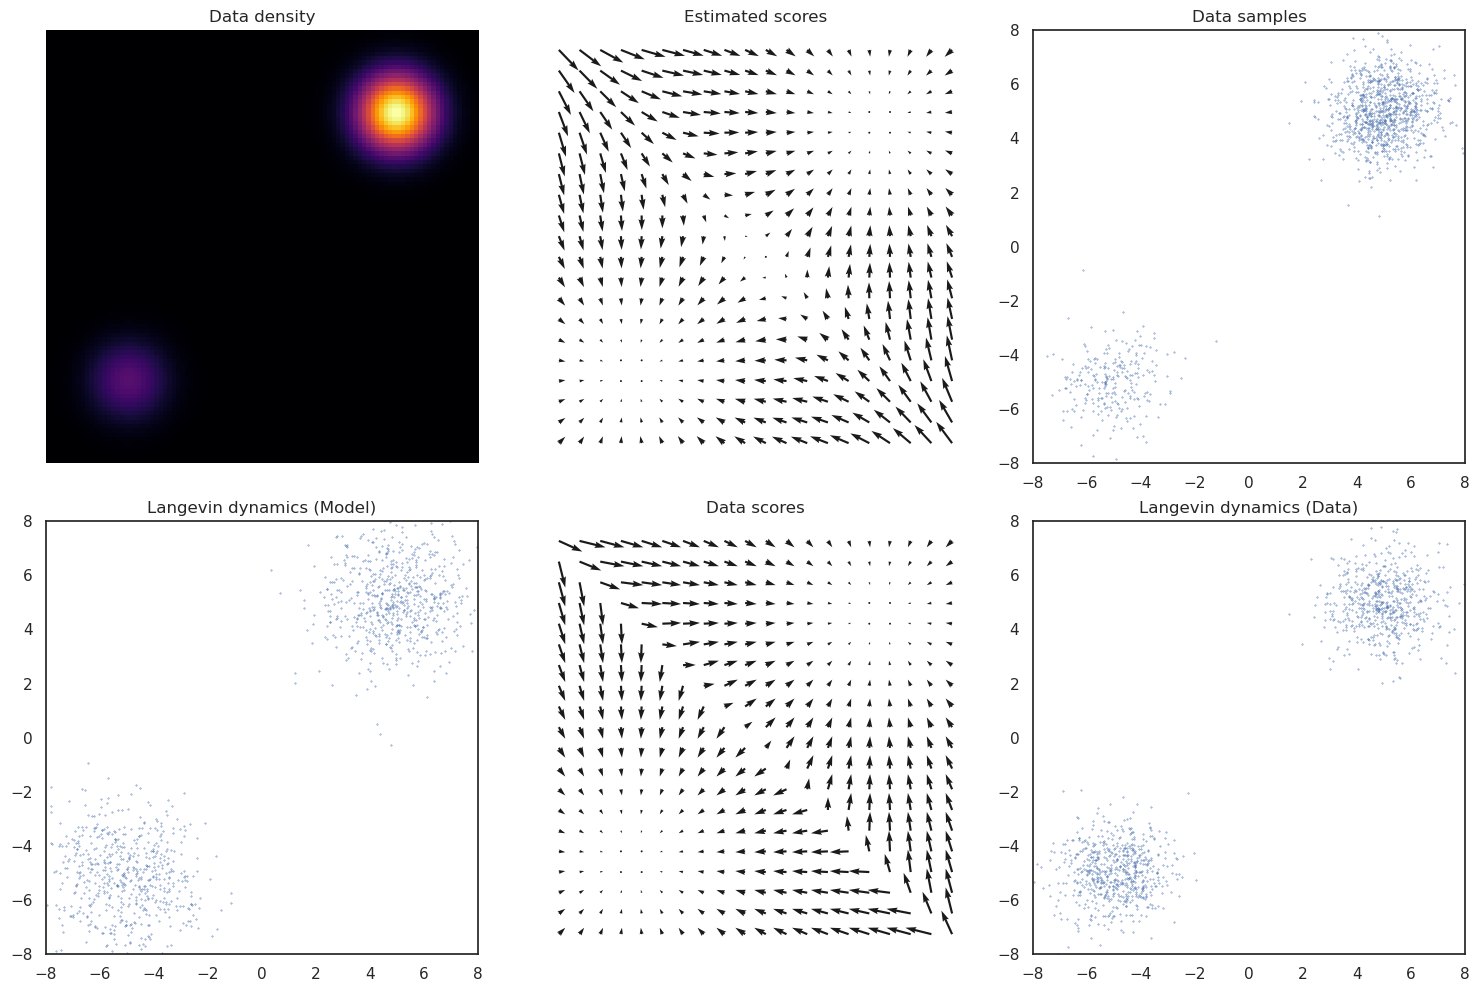

In [22]:
hidden_units = 128
score = nn.Sequential(
    nn.Linear(2, hidden_units),
    nn.Softplus(),
    nn.Linear(hidden_units, hidden_units),
    nn.Softplus(),
    nn.Linear(hidden_units, 2),
)

teacher = GMMDist(dim=2)
optimizer = optim.Adam(score.parameters(), lr=0.001)

for step in range(10000):
    samples = teacher.sample((128,))

    loss = dsm_score_estimation(score, samples, sigma=1.)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    logging.info('step: {}, loss: {}'.format(step, loss.item()))

visualize_score_matching(teacher, score, -8, 8, savefig=None, step=step)

Using device: cuda


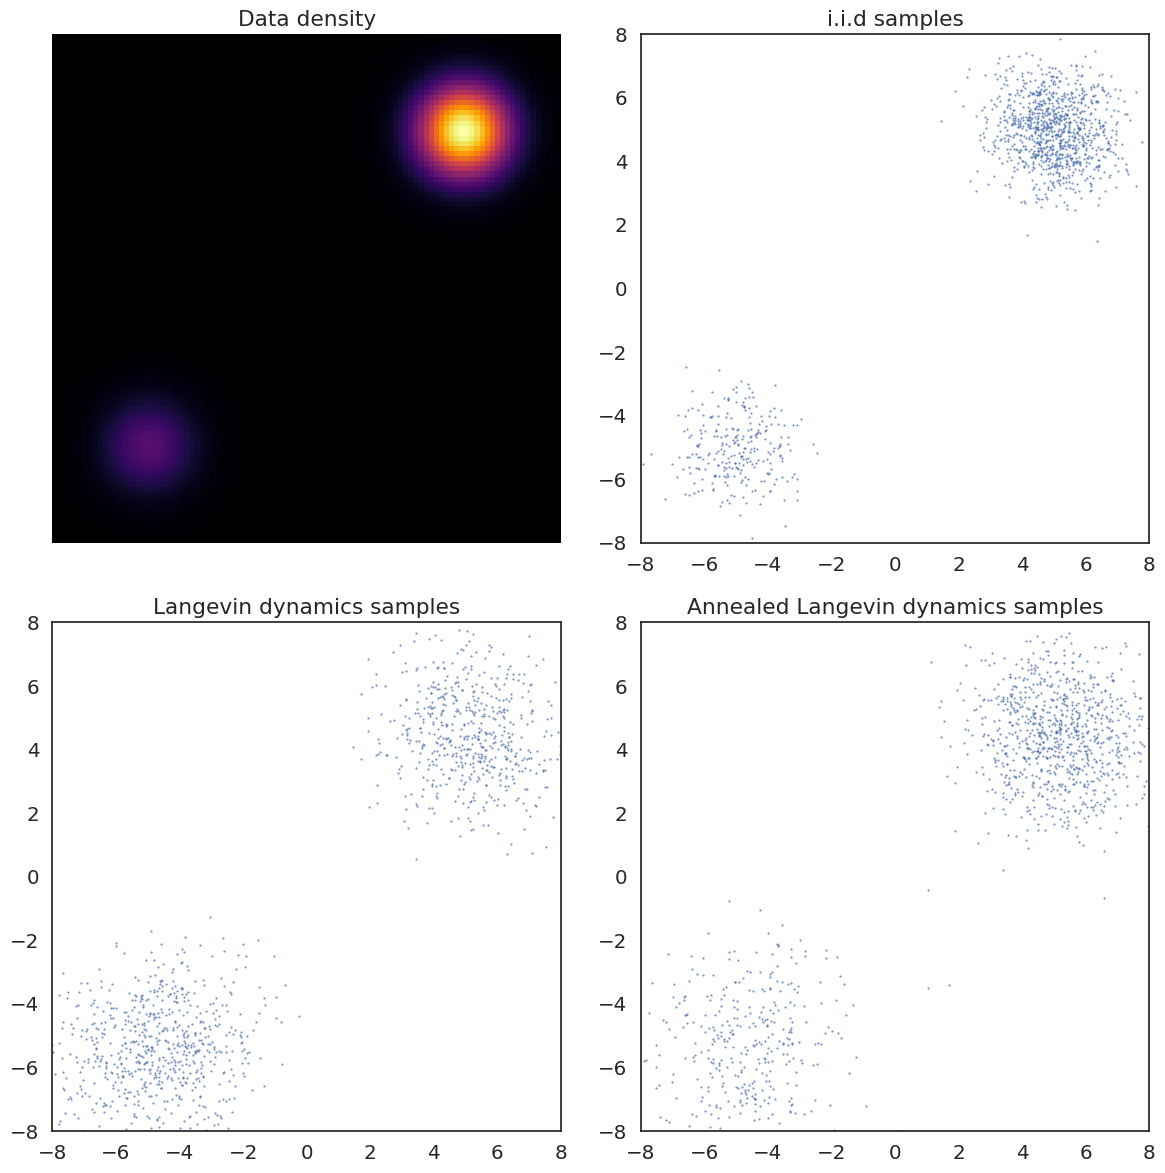

/tmp/ipykernel_166712/2887075540.py:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


GIF saved as annealed_scores.gif


In [23]:
# Training the Annealed Score Network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

teacher_anneal = GMMDistAnneal(dim=2)
# Denser range of sigmas for smoother GIF
sigmas = torch.tensor(np.exp(np.linspace(np.log(20), 0., 50))).float().to(device)

score_anneal = ConditionalScoreNet(n_classes=50, hidden_units=128).to(device)
optimizer_anneal = optim.Adam(score_anneal.parameters(), lr=0.001)

for step in range(10000):
    samples = teacher_anneal.sample((128,)).to(device)
    labels = torch.randint(0, len(sigmas), (128,)).to(device)
    
    loss = anneal_dsm_score_estimation(score_anneal, samples, labels, sigmas)

    optimizer_anneal.zero_grad()
    loss.backward()
    optimizer_anneal.step()

    if step % 1000 == 0:
        logging.info('step: {}, loss: {}'.format(step, loss.item()))

# Wrapper for the trained model to be compatible with visualization
def trained_score_fn(x, sigma):
    # Find the label index corresponding to sigma
    # We assume sigma is one of the values in sigmas
    diff = (sigmas - sigma).abs()
    label = torch.argmin(diff)
    labels = torch.ones(x.shape[0], dtype=torch.long).to(device) * label
    return score_anneal(x, labels)

# Run the visualization
visualize_annealed_langevin(teacher_anneal, trained_score_fn, sigmas.cpu().numpy(), device=device)

In [24]:
np.linspace(np.log(20), 0., 20)

array([2.99573227, 2.83806215, 2.68039203, 2.52272191, 2.36505179,
       2.20738168, 2.04971156, 1.89204144, 1.73437132, 1.5767012 ,
       1.41903108, 1.26136096, 1.10369084, 0.94602072, 0.7883506 ,
       0.63068048, 0.47301036, 0.31534024, 0.15767012, 0.        ])